In [ ]:
import numpy as np
import pandas as pd
from spec_id import Error, Analyze_Stack_avgage_cont_feat,Oldest_galaxy, Analyze_Stack_avgage_cont_feat_gal_age_correct,Get_parameters,\
    Combine_1D_parameters, Galaxy_ids
import matplotlib.pyplot as plt
from matplotlib import gridspec
from vtl.Readfile import Readfile
from glob import glob
from astropy.io import fits, ascii
from astropy.table import Table
from scipy.interpolate import interp1d,interp2d
import os
import cPickle
import seaborn as sea
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
colmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)

In [ ]:
gids=Galaxy_ids('masslist_mar22.dat')
metal=np.arange(0.002,0.031,0.001)
age=np.arange(.5,6.1,.1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [ ]:
bfm,mmean,mle,mhe,bfa,amean,ale,ahe=np.zeros([8,len(gids.ids)])

for i in range(len(gids.ids)):
    bfm[i],mmean[i],mle[i],mhe[i],bfa[i],amean[i],ale[i],ahe[i]=Get_parameters(gids.ids[i],gids.rshift[i],metal,age,tau)

In [5]:
param_table=pd.DataFrame({'ids':gids.ids, 'rshift':gids.rshift, 'lmass':gids.lmass, 'compactiveness':gids.comp,'bfmetal':bfm,
                          'm_mean':mmean,'l_1sig_m':mle,'h_1sig_m':mhe,'bfage':bfa,'a_mean':amean,'l_1sig_a':ale,'h_1sig_a':ahe})

In [11]:
param_table.to_pickle('parameter_fits')

In [ ]:
param_table = pd.read_pickle('parameter_fits')

In [7]:
colors=np.zeros(len(gids.ids)).astype(str)
p=['o', 'v', '>', 's', 'p', '*', 'd', 'D']
points=np.zeros(len(gids.ids)).astype(str)
a,b,c,d,e=[[],[],[],[],[]]

for i in range(len(gids.rshift)):
    if 1.0 < gids.rshift[i] <= 1.1:
        colors[i]='#AB3843'
        a.append(i)
        points[i]=p[len(a)]
    if 1.1 < gids.rshift[i] <= 1.2:
        colors[i]='#B18F3A'
        b.append(i)
        points[i]=p[len(b)]
    if 1.2 < gids.rshift[i] <= 1.3:
        colors[i]='#429431'
        c.append(i)
        points[i]=p[len(c)]
    if 1.3 < gids.rshift[i] <= 1.4:
        colors[i]='#0D94D5'
        d.append(i)
        points[i]=p[len(d)]
    if 1.6 < gids.rshift[i] <= 1.7:
        colors[i]='#562D77'
        e.append(i)
        points[i]=p[len(e)]

print points

['v' 'v' '>' 's' 'v' '>' 's' 'p' '*' 'p' 'v' '>' 's' 'p' 'v' 'd' 'D' '>'
 '>' '*' 'd' 'D' 's' '*' 'd']


In [ ]:
l_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids_lz]
l_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids_lz]

m_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids_mz]
m_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids_mz]

h_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids_hz]
h_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids_hz]

In [ ]:
lz_params=Combine_1D_parameters(l_cont_list,l_feat_list,gids.speclist_lz,gids.rshift_lz,tau,metal,age)
mz_params=Combine_1D_parameters(m_cont_list,m_feat_list,gids.speclist_mz,gids.rshift_mz,tau,metal,age)
hz_params=Combine_1D_parameters(h_cont_list,h_feat_list,gids.speclist_hz,gids.rshift_hz,tau,metal,age)

lz_params.Get_age()
mz_params.Get_age()
hz_params.Get_age()

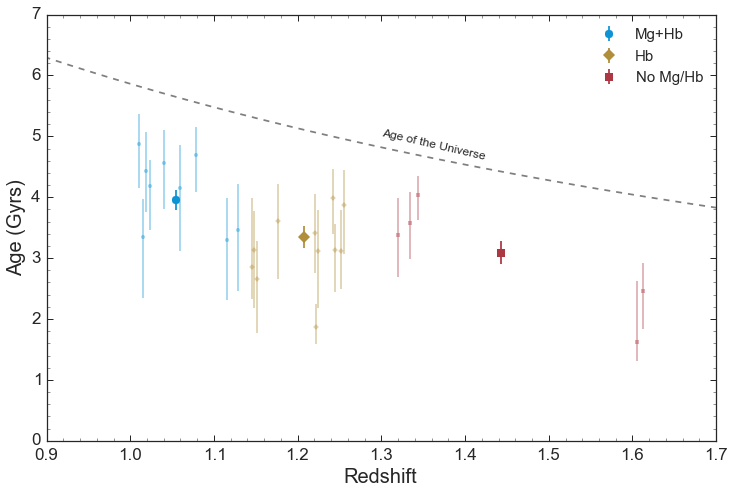

In [49]:
%matplotlib inline

z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)

plt.errorbar(gids.rshift_lz,param_table['a_mean'][gids.IDlz],yerr=[param_table['l_1sig_a'][gids.IDlz],
            param_table['h_1sig_a'][gids.IDlz]],color='#0D94D5',alpha=.4,ms=4,fmt='o')
plt.errorbar(gids.rshift_mz,param_table['a_mean'][gids.IDmz],yerr=[param_table['l_1sig_a'][gids.IDmz],
            param_table['h_1sig_a'][gids.IDmz]],color='#B18F3A',alpha=.4,ms=4,fmt='D')
plt.errorbar(gids.rshift_hz,param_table['a_mean'][gids.IDhz],yerr=[param_table['l_1sig_a'][gids.IDhz],
            param_table['h_1sig_a'][gids.IDhz]],color='#AB3843',alpha=.4,ms=4,fmt='s')
plt.errorbar(np.mean(gids.rshift_lz),lz_params.amean,yerr=[[lz_params.ale,lz_params.ahe]],
             color='#0D94D5',ms=8,fmt='o',label='Mg+Hb')
plt.errorbar(np.mean(gids.rshift_mz),mz_params.amean,yerr=[[mz_params.ale,mz_params.ahe]],
             color='#B18F3A',ms=8,fmt='D',label='Hb')
plt.errorbar(np.mean(gids.rshift_hz),hz_params.amean,yerr=[[hz_params.ale,hz_params.ahe]],
             color='#AB3843',ms=8,fmt='s',label='No Mg/Hb')

plt.axis([0.9,1.7,0,7])
plt.xlabel('Redshift',size=20)
plt.ylabel('Age (Gyrs)',size=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.text(1.3,5.,'Age of the Universe',rotation=-13,fontsize=12)
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=15)
plt.show()
# plt.savefig('../important_plots/agevz_featgroup.png')
plt.close()

In [13]:
print lz_params.amean/Oldest_galaxy(np.mean(gids.rshift_lz))
print mz_params.amean/Oldest_galaxy(np.mean(gids.rshift_mz))
print hz_params.amean/Oldest_galaxy(np.mean(gids.rshift_hz))


plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.axhline(1,color='k',linestyle='--',alpha=.5)
plt.plot(param_table['a_mean'][gids.IDlz],param_table['a_mean'][gids.IDlz]/Oldest_galaxy(gids.rshift_lz),'o',
         color='#0D94D5',alpha=.4,ms=4)
plt.plot(param_table['a_mean'][gids.IDmz],param_table['a_mean'][gids.IDmz]/Oldest_galaxy(gids.rshift_mz),'D',
         color='#B18F3A',alpha=.4,ms=4)
plt.plot(param_table['a_mean'][gids.IDhz],param_table['a_mean'][gids.IDhz]/Oldest_galaxy(gids.rshift_hz),'s',
         color='#AB3843',alpha=.4,ms=4)
plt.errorbar(lz_params.amean,lz_params.amean/Oldest_galaxy(np.mean(gids.rshift_lz)),xerr=[[lz_params.ale,lz_params.ahe]],
             yerr=[np.array([lz_params.ale,lz_params.ahe])/Oldest_galaxy(np.mean(gids.rshift_lz))],color='#0D94D5',ms=8,
             fmt='o',label='Mg+Hb')
plt.errorbar(mz_params.amean,mz_params.amean/Oldest_galaxy(np.mean(gids.rshift_mz)),xerr=[[mz_params.ale,mz_params.ahe]],
             yerr=[np.array([mz_params.ale,mz_params.ahe])/Oldest_galaxy(np.mean(gids.rshift_mz))],color='#B18F3A',ms=8,
             fmt='D',label='Hb')
plt.errorbar(hz_params.amean,hz_params.amean/Oldest_galaxy(np.mean(gids.rshift_hz)),xerr=[[hz_params.ale,hz_params.ahe]],
             yerr=[np.array([hz_params.ale,hz_params.ahe])/Oldest_galaxy(np.mean(gids.rshift_hz))],color='#AB3843',ms=8,
             fmt='s',label='no Mg/Hb')
plt.axis([1.2,5.2,0,1])
plt.xlabel('Age (Gyrs)',size=20)
plt.ylabel('Percent Age of The Universe',size=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(loc=4,fontsize=15)
# plt.show()
plt.savefig('../important_plots/percent_age_featgroup.png')
plt.close()

0.701219653625
0.654673089388
0.698870752422


In [ ]:
ml_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids_ml]
ml_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids_ml]

mm_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids_mm]
mm_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids_mm]

mh_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids_mh]
mh_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids_mh]

In [ ]:
ml_params=Combine_1D_parameters(ml_cont_list,ml_feat_list,gids.speclist_ml,gids.rshift_ml,tau,metal,age)
mm_params=Combine_1D_parameters(mm_cont_list,mm_feat_list,gids.speclist_mm,gids.rshift_mm,tau,metal,age)
mh_params=Combine_1D_parameters(mh_cont_list,mh_feat_list,gids.speclist_mh,gids.rshift_mh,tau,metal,age)

ml_params.Get_metallicity()
mm_params.Get_metallicity()
mh_params.Get_metallicity()

In [4]:
logm,gmetal=Readfile('Gallazzi_12.dat',0)
cvx,cvy=Readfile('Gallazzi_12_line.dat',0)
cv1x,cv1y=Readfile('gallazzi_points_curve1.dat',0)

glist,sgm,sgler,sgher,sgmass=Readfile('sg_fit_metals.dat',is_float=False)
sgm,sgler,sgher,sgmass=np.array([sgm,sgler,sgher,sgmass]).astype(float)

In [ ]:
plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3)#, label='SDSS')
# sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.3)#, label='Gallazzi+14 best fit line')
# galbf=plt.axhline(y=5,color='k',alpha=.5)
gal=plt.scatter(logm,gmetal,zorder=3,color='k',alpha=.3)#,label='Gallazzi+14,z=0.7')

#####single galaxy points
plt.errorbar(gids.lmass_ml,np.log10(param_table['m_mean'][gids.IDml]/0.019),
             yerr=np.log10([(param_table['m_mean']/(param_table['m_mean']-param_table['l_1sig_m']))[gids.IDml],
                            (param_table['h_1sig_m']/param_table['m_mean']+1)[gids.IDml]])
             ,color='#F5AB12',alpha=.4,ms=5,fmt='o')
plt.errorbar(gids.lmass_mm,np.log10(param_table['m_mean'][gids.IDmm]/0.019),
             yerr=np.log10([(param_table['m_mean']/(param_table['m_mean']-param_table['l_1sig_m']))[gids.IDmm],
                            (param_table['h_1sig_m']/param_table['m_mean']+1)[gids.IDmm]])
             ,color='#13D6FF',alpha=.4,ms=5,fmt='D')
plt.errorbar(gids.lmass_mh,np.log10(param_table['m_mean'][gids.IDmh]/0.019),
             yerr=np.log10([(param_table['m_mean']/(param_table['m_mean']-param_table['l_1sig_m']))[gids.IDmh],
                            (param_table['h_1sig_m']/param_table['m_mean']+1)[gids.IDmh]])
             ,color='#6C1DE8',alpha=.4,ms=5,fmt='s')
plt.errorbar(np.mean(gids.lmass_ml),np.log10(ml_params.mmean/0.019),
             yerr=np.log10([[ml_params.mmean/(ml_params.mmean-ml_params.mle)],[ml_params.mhe/ml_params.mmean+1]]),
             color='#F5AB12',ms=8,fmt='o',label='10 < log(M/M$_\odot$) < 10.7')
plt.errorbar(np.mean(gids.lmass_mm),np.log10(mm_params.mmean/0.019),
             yerr=np.log10([[mm_params.mmean/(mm_params.mmean-mm_params.mle)],[mm_params.mhe/mm_params.mmean+1]]),
             color='#13D6FF',ms=8,fmt='D',label='10.7 < log(M/M$_\odot$) < 10.9')
plt.errorbar(np.mean(gids.lmass_mh),np.log10(mh_params.mmean/0.019),
             yerr=np.log10([[mh_params.mmean/(mh_params.mmean-mh_params.mle)],[mh_params.mhe/mh_params.mmean+1]]),
             color='#6C1DE8',ms=8,fmt='s',label='10.9 < log(M/M$_\odot$)')

plt.xlabel('log(M/M$_\odot$)',size=20)
plt.ylabel('log(Z/Z$_\odot$)',size=20)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(loc=4,fontsize=15)
# plt.show()
plt.savefig('../important_plots/metalmass_massgroup.png')
plt.close()

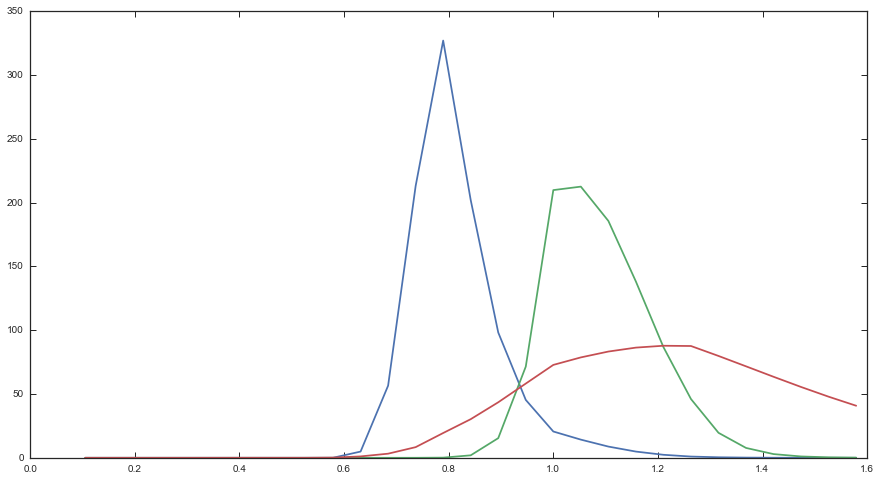

In [110]:
plt.figure(figsize=[15,8])
plt.plot(metal/.019,mh_params.m_dist)
plt.plot(metal/.019,mm_params.m_dist)
plt.plot(metal/.019,ml_params.m_dist)
plt.show()
plt.close()

In [ ]:
all_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids]
all_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids]

all_params=Combine_1D_parameters(all_cont_list,all_feat_list,gids.speclist,gids.rshift,tau,metal,age)
all_params.Get_metallicity()
all_params.Get_age()

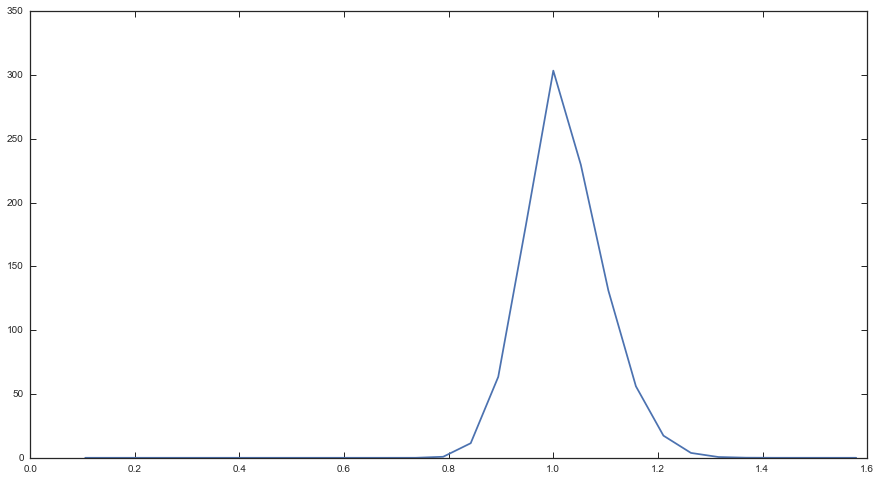

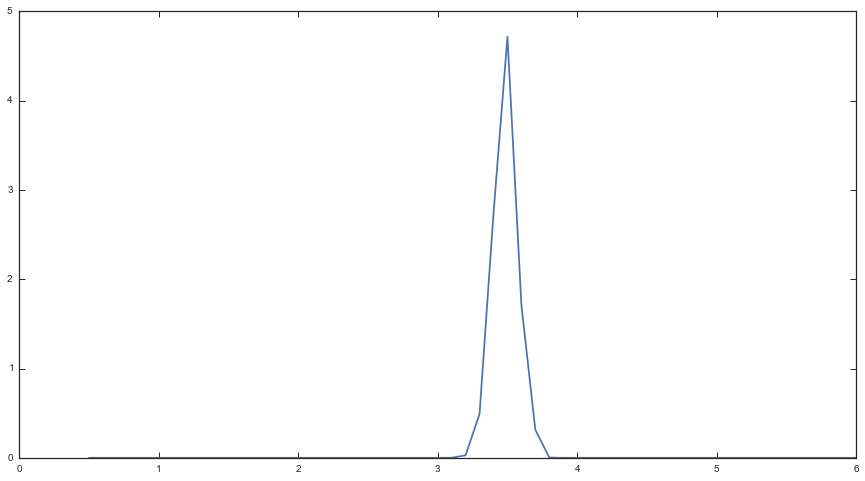

In [112]:
plt.figure(figsize=[15,8])
plt.plot(metal/.019,all_params.m_dist)
plt.show()
plt.close()

plt.figure(figsize=[15,8])
plt.plot(age,all_params.a_dist)
plt.show()
plt.close()

In [ ]:
lz_params.Get_metallicity()
mz_params.Get_metallicity()
hz_params.Get_metallicity()

1.10642337306
0.678198502268
1.35449847063


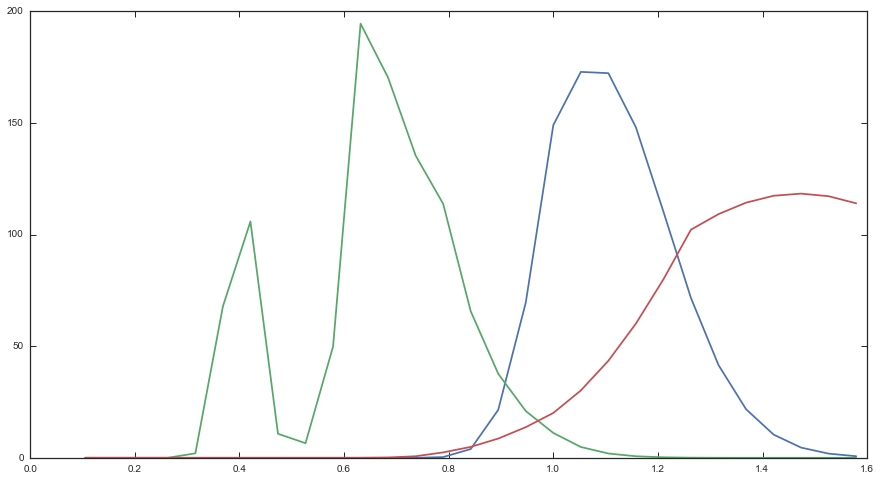

In [32]:
print lz_params.mmean/.019
print mz_params.mmean/.019
print hz_params.mmean/.019


plt.figure(figsize=[15,8])
plt.plot(metal/.019,lz_params.m_dist)
plt.plot(metal/.019,mz_params.m_dist)
plt.plot(metal/.019,hz_params.m_dist)
plt.show()
plt.close()

In [ ]:
plt.figure(figsize=[12,8])
currentAxis = plt.gca()

####gallazzi points
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)#, label='SDSS')
# sdss=plt.axhline(y=5,linestyle='--',color='k',alpha=.5)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.3,ms=4)#, label='Gallazzi+14 best fit line')
# galbf=plt.axhline(y=5,color='k',alpha=.5)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)#,label='Gallazzi+14,z=0.7')

#####single galaxy points
plt.errorbar(gids.lmass_lz,np.log10(param_table['m_mean'][gids.IDlz]/0.019),
             yerr=np.log10([(param_table['m_mean']/(param_table['m_mean']-param_table['l_1sig_m']))[gids.IDlz],
                            (param_table['h_1sig_m']/param_table['m_mean']+1)[gids.IDlz]])
             ,color='#0D94D5',alpha=.4,ms=5,fmt='o')
plt.errorbar(gids.lmass_mz,np.log10(param_table['m_mean'][gids.IDmz]/0.019),
             yerr=np.log10([(param_table['m_mean']/(param_table['m_mean']-param_table['l_1sig_m']))[gids.IDmz],
                            (param_table['h_1sig_m']/param_table['m_mean']+1)[gids.IDmz]])
             ,color='#B18F3A',alpha=.4,ms=5,fmt='D')
plt.errorbar(gids.lmass_hz,np.log10(param_table['m_mean'][gids.IDhz]/0.019),
             yerr=np.log10([(param_table['m_mean']/(param_table['m_mean']-param_table['l_1sig_m']))[gids.IDhz],
                            (param_table['h_1sig_m']/param_table['m_mean']+1)[gids.IDhz]])
             ,color='#AB3843',alpha=.4,ms=5,fmt='s')
plt.errorbar(np.mean(gids.lmass_lz),np.log10(lz_params.mmean/0.019),
             yerr=np.log10([[lz_params.mmean/(lz_params.mmean-lz_params.mle)],[lz_params.mhe/lz_params.mmean+1]]),
             color='#0D94D5',ms=8,fmt='o',label='Mg+Hb')
plt.errorbar(np.mean(gids.lmass_mz),np.log10(mz_params.mmean/0.019),
             yerr=np.log10([[mz_params.mmean/(mz_params.mmean-mz_params.mle)],[mz_params.mhe/mz_params.mmean+1]]),
             color='#B18F3A',ms=8,fmt='D',label='Hb')
plt.errorbar(np.mean(gids.lmass_hz),np.log10(hz_params.mmean/0.019),
             yerr=np.log10([[hz_params.mmean/(hz_params.mmean-hz_params.mle)],[hz_params.mhe/hz_params.mmean+1]]),
             color='#AB3843',ms=8,fmt='s',label='No Mg/Hb')

plt.xlabel('log(M/M$_\odot$)',size=20)
plt.ylabel('log(Z/Z$_\odot$)',size=20)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(loc=4,fontsize=15)
plt.show()
# plt.savefig('../important_plots/metalmass_featgroup.png')
plt.close()

In [ ]:
a_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids_C]
a_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids_C]

b_cont_list=['chidat/%s_apr6_galfit_cont_chidata.fits' % U for U in gids.ids_D]
b_feat_list=['chidat/%s_apr6_galfit_feat_chidata.fits' % U for U in gids.ids_D]

a_params=Combine_1D_parameters(a_cont_list,a_feat_list,gids.speclist_C,gids.rshift_C,tau,metal,age)
b_params=Combine_1D_parameters(b_cont_list,b_feat_list,gids.speclist_D,gids.rshift_D,tau,metal,age)

a_params.Get_metallicity()
b_params.Get_metallicity()

a_params.Get_age()
b_params.Get_age()

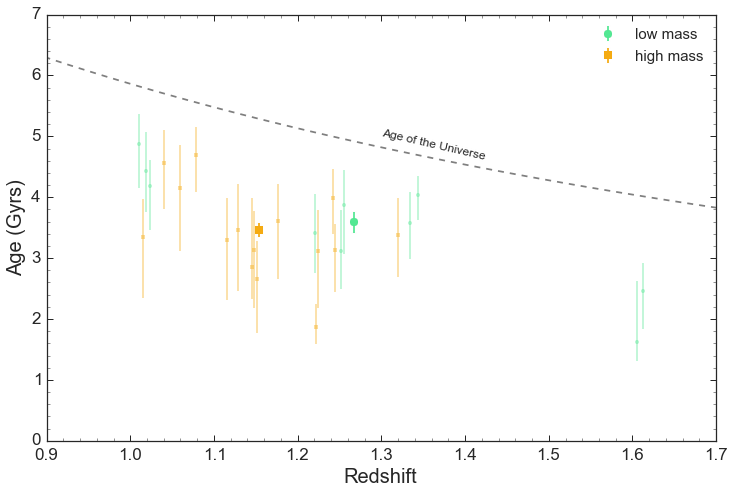

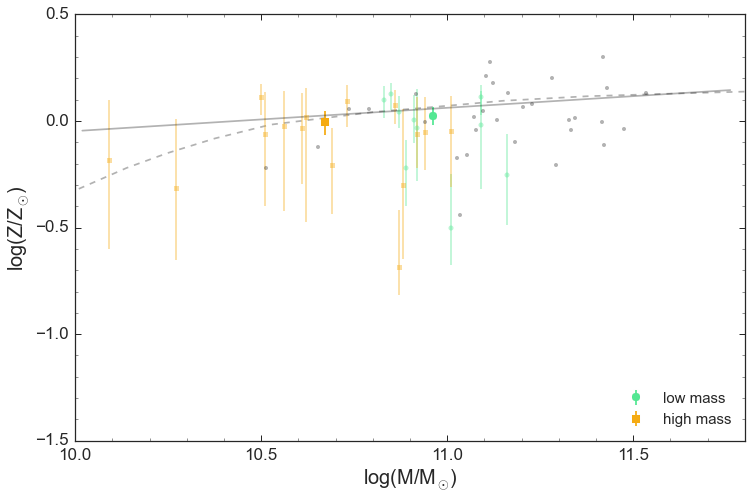

In [10]:
%matplotlib inline
z=np.linspace(0,2,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(z,ages,'k--',alpha=.5)
plt.errorbar(gids.rshift_C,param_table['a_mean'][gids.IDC],yerr=[param_table['l_1sig_a'][gids.IDC],
            param_table['h_1sig_a'][gids.IDC]],color='#53E893',alpha=.4,ms=4,fmt='o')
plt.errorbar(gids.rshift_D,param_table['a_mean'][gids.IDD],yerr=[param_table['l_1sig_a'][gids.IDD],
            param_table['h_1sig_a'][gids.IDD]],color='#F5AB12',alpha=.4,ms=4,fmt='s')
plt.errorbar(np.mean(gids.rshift_C),a_params.amean,yerr=[[a_params.ale,a_params.ahe]],
             color='#53E893',ms=8,fmt='o',label='low mass')
plt.errorbar(np.mean(gids.rshift_D),b_params.amean,yerr=[[b_params.ale,b_params.ahe]],
             color='#F5AB12',ms=8,fmt='s',label='high mass')
plt.axis([0.9,1.7,0,7])
plt.xlabel('Redshift',size=20)
plt.ylabel('Age (Gyrs)',size=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.text(1.3,5.,'Age of the Universe',rotation=-13,fontsize=12)
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(fontsize=15)
plt.show()
# plt.savefig('../important_plots/agevz_sizegroup.png')
plt.close()

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.plot(cv1x,cv1y,'--',zorder=1,color='k',alpha=.3,markersize=4)
plt.plot(cvx,cvy,zorder=2,color='k',alpha=.3,ms=4)
plt.plot(logm,gmetal,'o',zorder=3,color='k',alpha=.3,markersize=4)
plt.errorbar(gids.lmass_C,np.log10(param_table['m_mean'][gids.IDC]/0.019),
             yerr=np.log10([(param_table['m_mean']/(param_table['m_mean']-param_table['l_1sig_m']))[gids.IDC],
                            (param_table['h_1sig_m']/param_table['m_mean']+1)[gids.IDC]])
             ,color='#53E893',alpha=.4,ms=5,fmt='o')
plt.errorbar(gids.lmass_D,np.log10(param_table['m_mean'][gids.IDD]/0.019),
             yerr=np.log10([(param_table['m_mean']/(param_table['m_mean']-param_table['l_1sig_m']))[gids.IDD],
                            (param_table['h_1sig_m']/param_table['m_mean']+1)[gids.IDD]])
             ,color='#F5AB12',alpha=.4,ms=5,fmt='s')
plt.errorbar(np.mean(gids.lmass_C),np.log10(a_params.mmean/0.019),
             yerr=np.log10([[a_params.mmean/(a_params.mmean-a_params.mle)],[a_params.mhe/a_params.mmean+1]]),
             color='#53E893',ms=8,fmt='o',label='low mass')
plt.errorbar(np.mean(gids.lmass_D),np.log10(b_params.mmean/0.019),
             yerr=np.log10([[b_params.mmean/(b_params.mmean-b_params.mle)],[b_params.mhe/b_params.mmean+1]]),
             color='#F5AB12',ms=8,fmt='s',label='high mass')
plt.xlabel('log(M/M$_\odot$)',size=20)
plt.ylabel('log(Z/Z$_\odot$)',size=20)
plt.axis([10,11.8,-1.5,.5])
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(loc=4,fontsize=15)
plt.show()
# plt.savefig('../important_plots/metalmass_sizegroup.png')
plt.close()

In [ ]:
# z=np.linspace(0,4,100)
# ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[12,8])
currentAxis = plt.gca()
plt.axhline(1,color='k',linestyle='--',alpha=.5)
plt.plot(param_table['a_mean'][gids.IDC],param_table['a_mean'][gids.IDC]/Oldest_galaxy(gids.rshift_C),'o',
         color='#53E893',alpha=.4,ms=4)
plt.plot(param_table['a_mean'][gids.IDD],param_table['a_mean'][gids.IDD]/Oldest_galaxy(gids.rshift_D),'s',
         color='#F5AB12',alpha=.4,ms=4)
plt.errorbar(a_params.amean,a_params.amean/Oldest_galaxy(np.mean(gids.rshift_C)),xerr=[[a_params.ale,a_params.ahe]],
             yerr=[np.array([a_params.ale,a_params.ahe])/Oldest_galaxy(np.mean(gids.rshift_C))],color='#53E893',ms=8,fmt='o',label='compact')
plt.errorbar(b_params.amean,b_params.amean/Oldest_galaxy(np.mean(gids.rshift_D)),xerr=[[b_params.ale,b_params.ahe]],
             yerr=[np.array([b_params.ale,b_params.ahe])/Oldest_galaxy(np.mean(gids.rshift_D))],color='#F5AB12',ms=8,fmt='s',label='extended')
plt.axis([1.2,5.2,0,1])
plt.xlabel('Age (Gyrs)',size=20)
plt.ylabel('Percent Age of The Universe',size=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.minorticks_on()
# plt.text(1.3,5.,'Age of the Universe',rotation=-13,fontsize=12)
plt.gcf().subplots_adjust(bottom=0.16)
plt.legend(loc=4,fontsize=15)
# plt.show()
plt.savefig('../important_plots/percent_age_sizegroup.png')
plt.close()

In [38]:
print a_params.amean/Oldest_galaxy(np.mean(gids.rshift_C))
print b_params.amean/Oldest_galaxy(np.mean(gids.rshift_D))

0.729344797122
0.655425828552


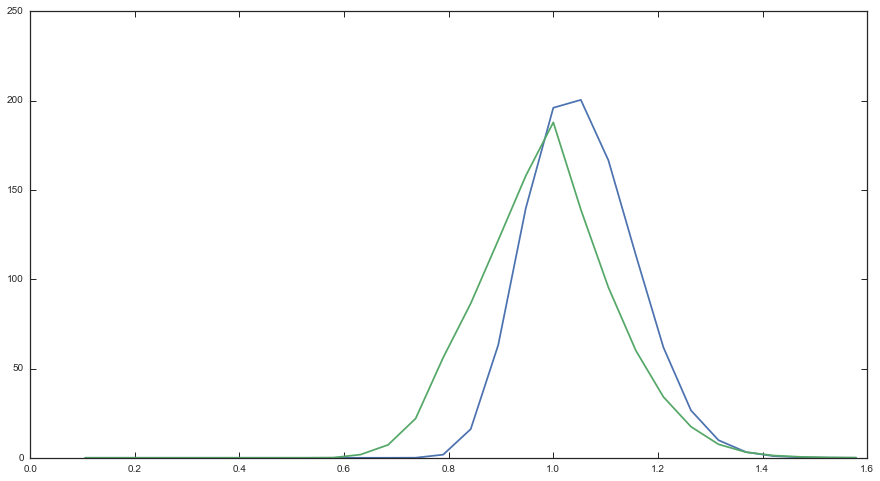

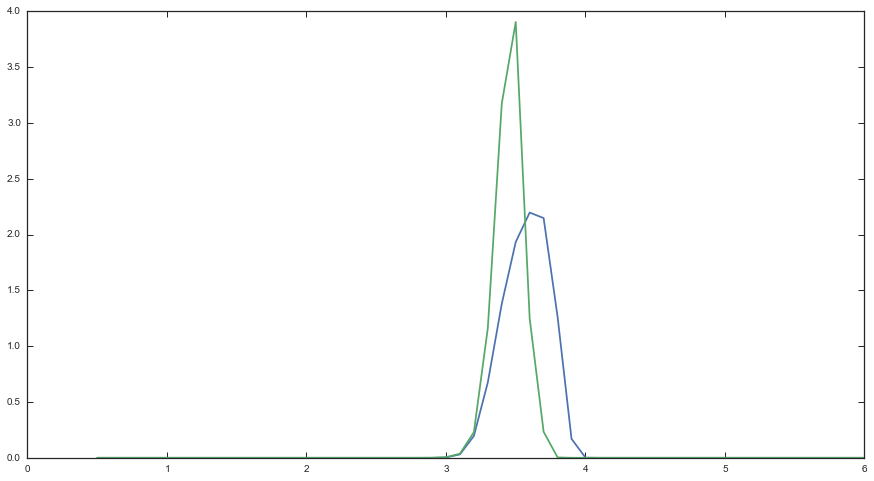

In [6]:
%matplotlib inline

plt.figure(figsize=[15,8])
plt.plot(metal/.019,a_params.m_dist)
plt.plot(metal/.019,b_params.m_dist)
plt.show()
plt.close()

plt.figure(figsize=[15,8])
plt.plot(age,a_params.a_dist)
plt.plot(age,b_params.a_dist)
plt.show()
plt.close()